In [7]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from datetime import datetime, timedelta
plt.style.use('seaborn-poster') 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
mars_weather_df = pd.read_csv("../local_datasets/mars_weather_data_cleaned.csv")

In [9]:
mars_weather_df.columns

Index(['Unnamed: 0', 'id', 'terrestrial_date', 'sol', 'ls', 'season',
       'min_temp', 'max_temp', 'pressure', 'pressure_string', 'abs_humidity',
       'wind_speed', 'wind_direction', 'atmo_opacity', 'sunrise', 'sunset',
       'local_uv_irradiance_index', 'min_gts_temp', 'max_gts_temp'],
      dtype='object')

In [10]:
mars_weather_df = mars_weather_df[
    ["terrestrial_date", "sol", "min_temp", "max_temp", "pressure", "min_gts_temp", "max_gts_temp"]
]

In [11]:
print(mars_weather_df.shape)
mars_weather_df.head()

(2950, 7)


,terrestrial_date,sol,min_temp,max_temp,pressure,min_gts_temp,max_gts_temp
0,2012-08-16,10,-75,-16,739,-83,8
1,2012-08-17,11,-76,-11,740,-83,9
2,2012-08-18,12,-76,-18,741,-82,8
3,2012-08-19,13,-74,-15,732,-80,8
4,2012-08-20,14,-74,-16,740,-82,9


In [12]:
mars_weather_df.isnull().sum(axis=0)

terrestrial_date    0
sol                 0
min_temp            0
max_temp            0
pressure            0
min_gts_temp        0
max_gts_temp        0
dtype: int64

In [13]:
mars_weather_df = mars_weather_df[
    (mars_weather_df.terrestrial_date > "2013-06-01") & (mars_weather_df.terrestrial_date < "2018-06-01")
]

In [14]:
mars_weather_df.terrestrial_date.min(), mars_weather_df.terrestrial_date.max()

('2013-06-02', '2018-05-31')

## Ensure data is ordered by time and equidistant with respect to time

In [10]:
mars_weather_df.terrestrial_date = pd.to_datetime(mars_weather_df.terrestrial_date)
mars_weather_df.sort_values("terrestrial_date", inplace=True)
diff = mars_weather_df.terrestrial_date - mars_weather_df.terrestrial_date.shift(1)
diff.value_counts()

1 days     1651
2 days       51
10 days       2
9 days        2
4 days        2
3 days        2
7 days        1
12 days       1
Name: terrestrial_date, dtype: int64

## Visualisations

In [11]:
def plot_weather_df(weather_df): 
    time_earth = weather_df.terrestrial_date
    time_mars = weather_df.sol
    
    plt.figure(figsize=(20, 7))
    sns.lineplot(time_earth, weather_df.min_temp, label="min air temp")
    sns.lineplot(time_earth, weather_df.max_temp, label="max air temp")
    plt.ylabel("temperature")
    plt.show()
    
    plt.figure(figsize=(20, 7))
    sns.lineplot(time_earth, weather_df.min_gts_temp, label="max ground temp")
    sns.lineplot(time_earth, weather_df.max_gts_temp, label="min ground temp")
    plt.ylabel("temperature")
    plt.show()
    
    plt.figure(figsize=(20, 7))
    sns.lineplot(time_earth, weather_df.pressure)
    plt.show()

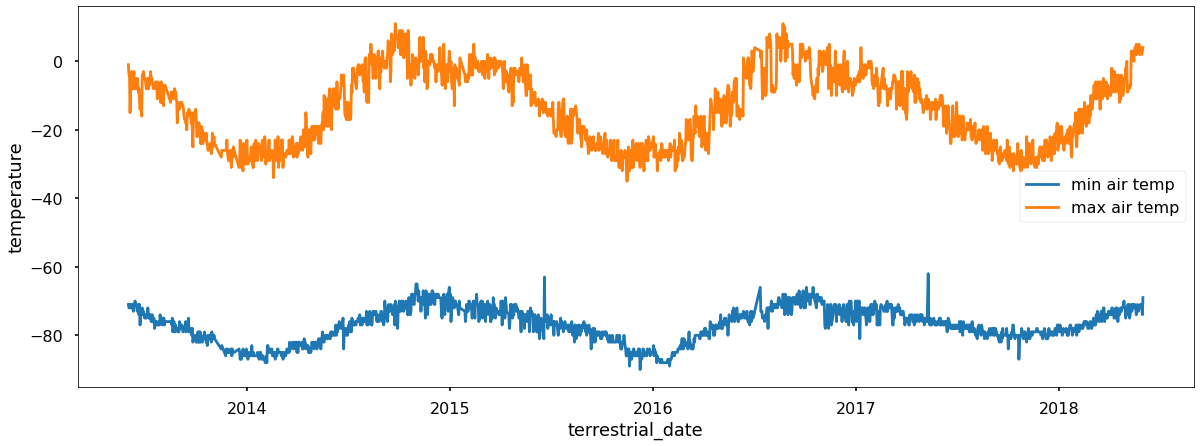

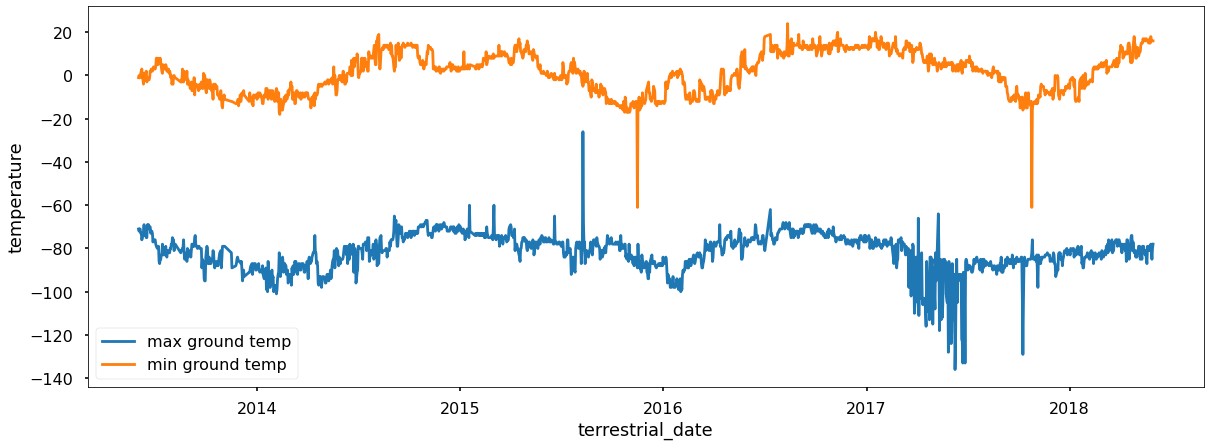

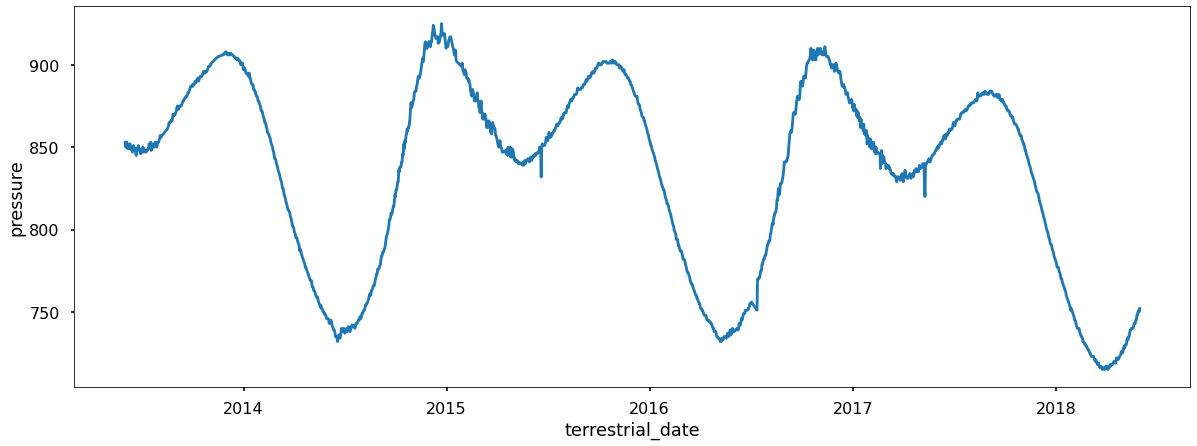

In [14]:
plot_weather_df(mars_weather_df)

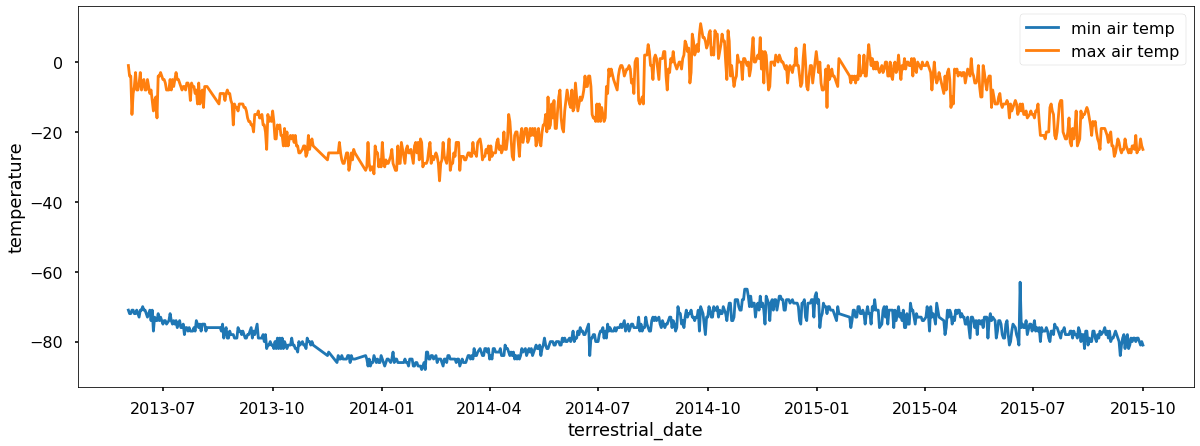

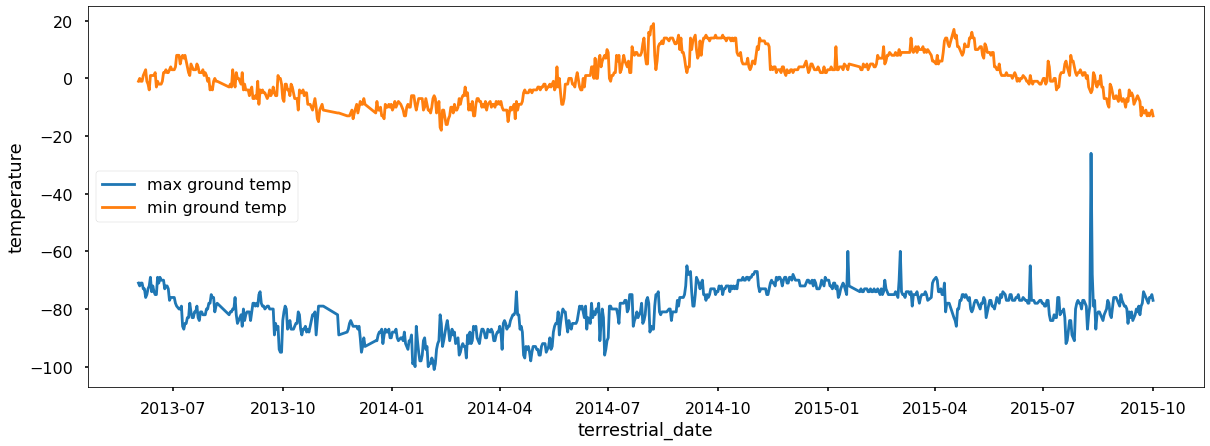

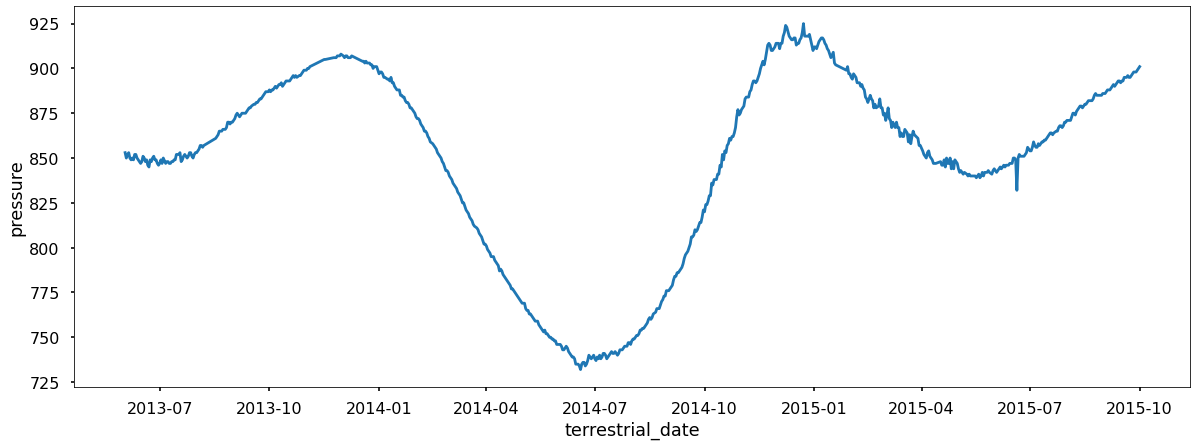

In [19]:
mars_weather_df_sample = mars_weather_df[(mars_weather_df.terrestrial_date <= "2015-10-01" )]
plot_weather_df(mars_weather_df_sample)

## Downsample to more easily trends in the data

In [11]:
weekly_resample_df = mars_weather_df.resample("7D", on="terrestrial_date").mean().reset_index(drop=False)
monthly_resample_df = mars_weather_df.resample("1M", on="terrestrial_date").mean().reset_index(drop=False)

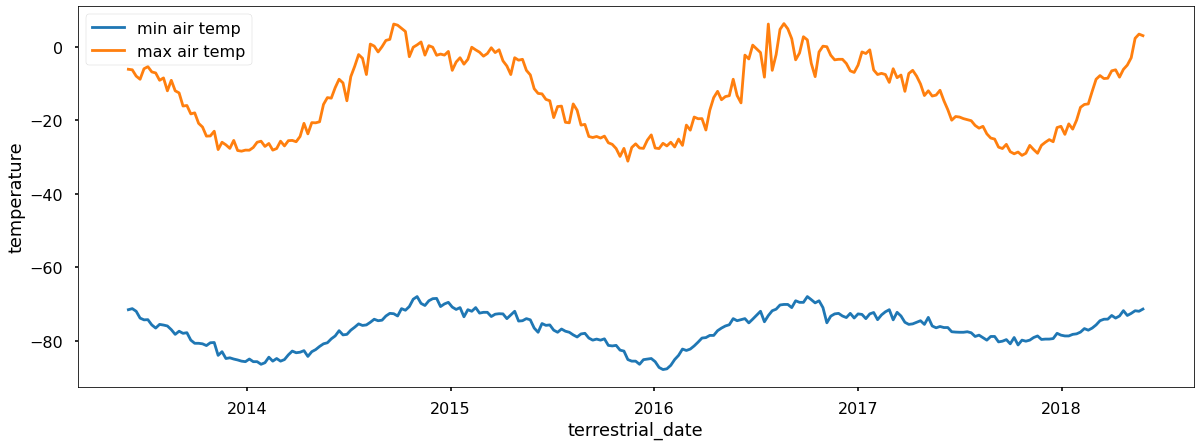

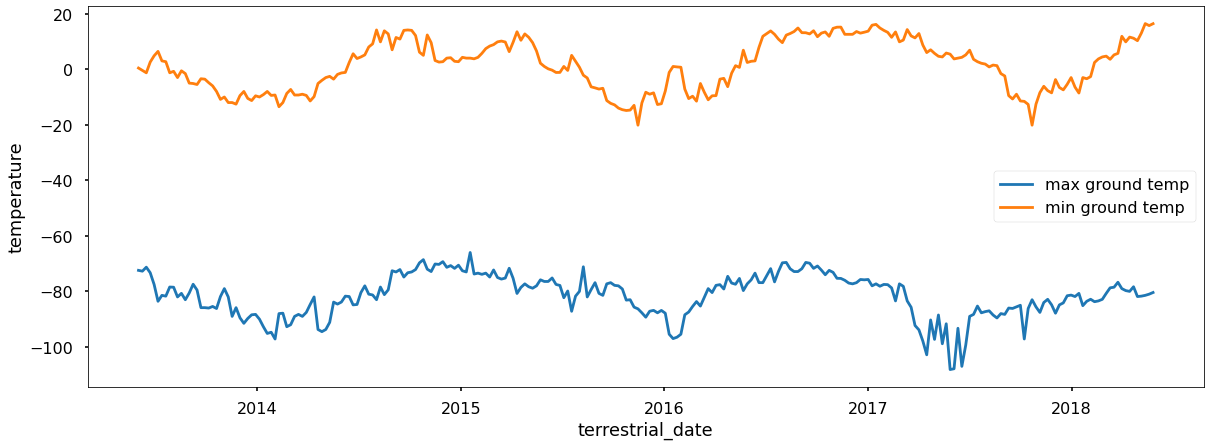

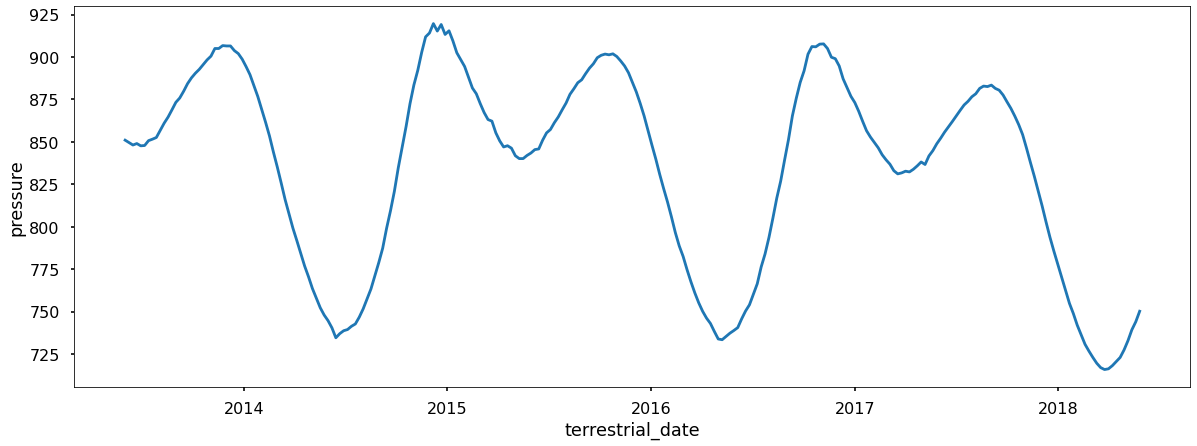

In [12]:
plot_weather_df(weekly_resample_df)

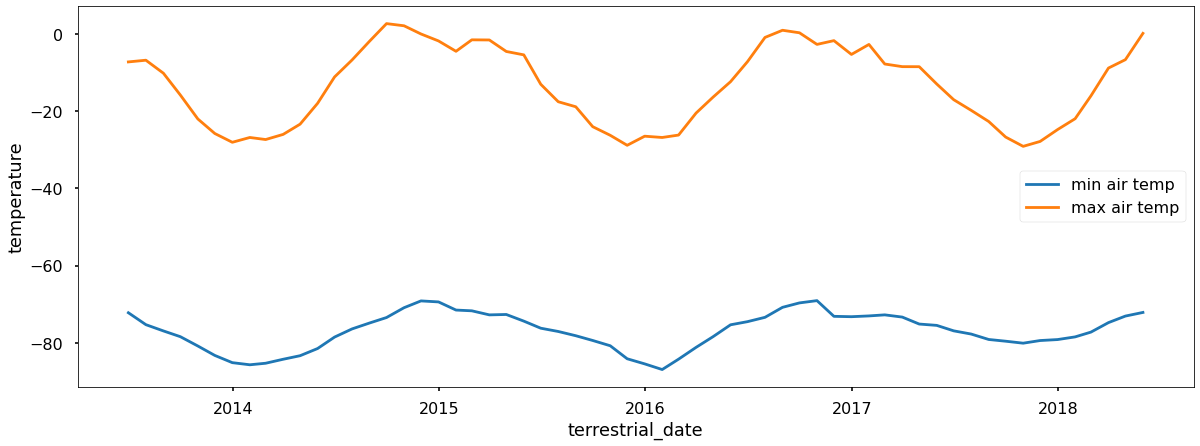

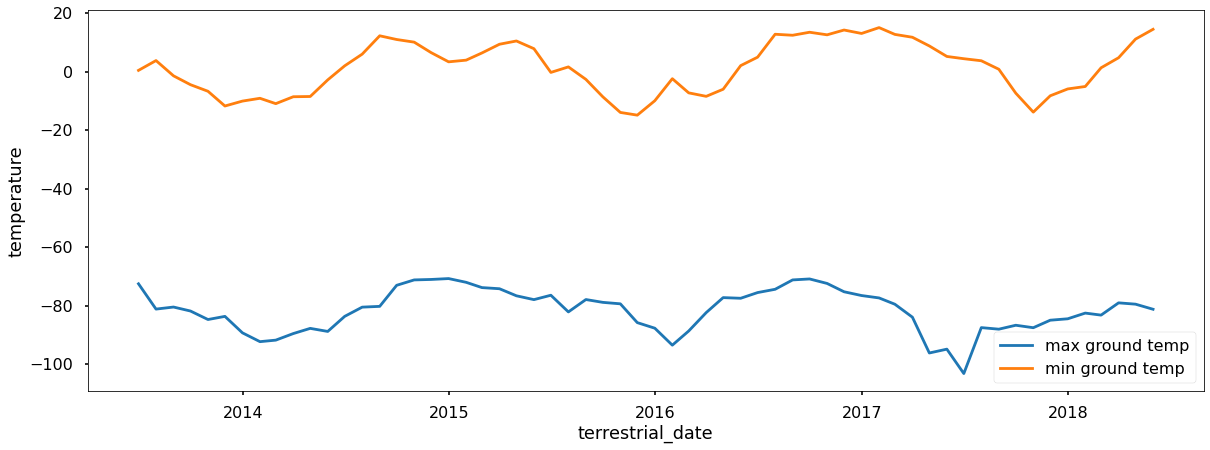

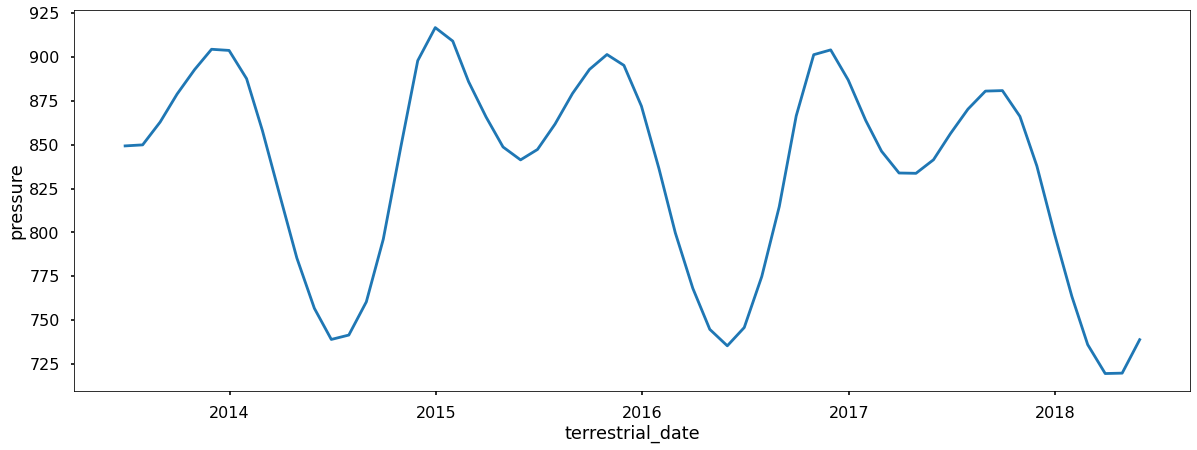

In [14]:
plot_weather_df(monthly_resample_df)

## Time Series Decomposition: 
- Decompose into level, trend, seasonality and noise.

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [18]:
def plot_signal_decomposition(df, column_name): 
    time_earth = df.terrestrial_date
    decomp = seasonal_decompose(df[column_name], period=52, model="additive", extrapolate_trend="freq")

    for quantity in [df[column_name], decomp.trend, decomp.seasonal, decomp.resid]: 
        plt.figure(figsize=(20, 7))
        sns.lineplot(time_earth, quantity)
        plt.show()

In [53]:
mars_weather_df.terrestrial_date.min(), mars_weather_df.terrestrial_date.max()

(Timestamp('2013-06-02 00:00:00'), Timestamp('2018-05-31 00:00:00'))

In [60]:
mars_weather_year= mars_weather_df[
    (mars_weather_df.terrestrial_date > "2014-01-01") & (mars_weather_df.terrestrial_date < "2017-01-01")
]
    

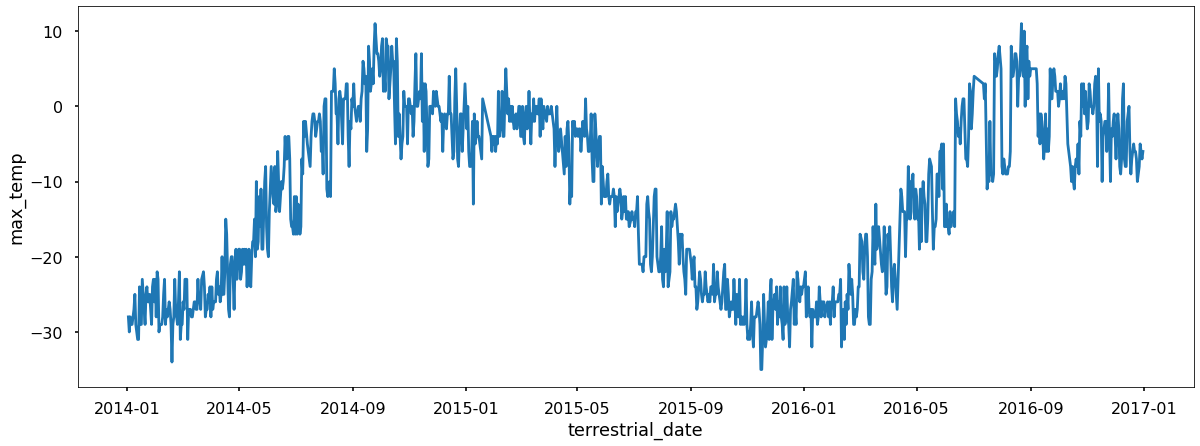

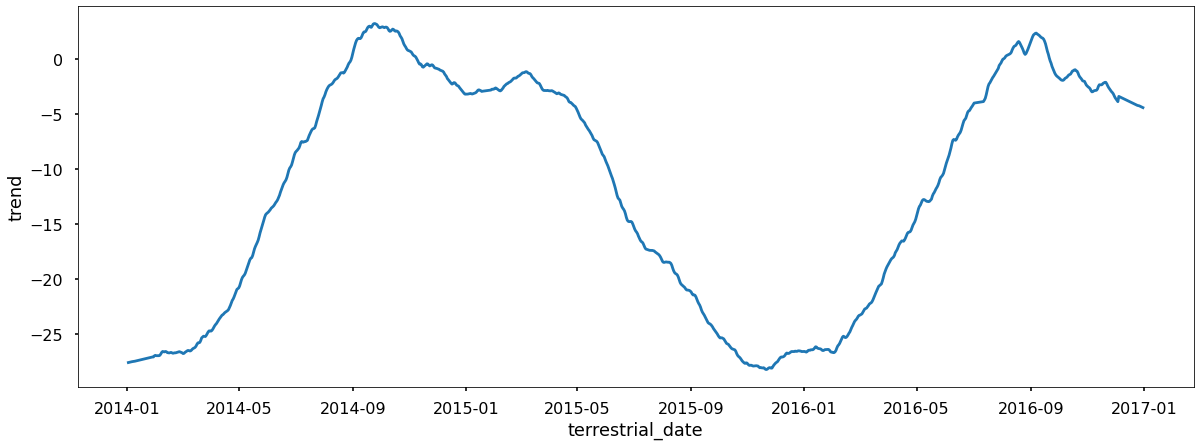

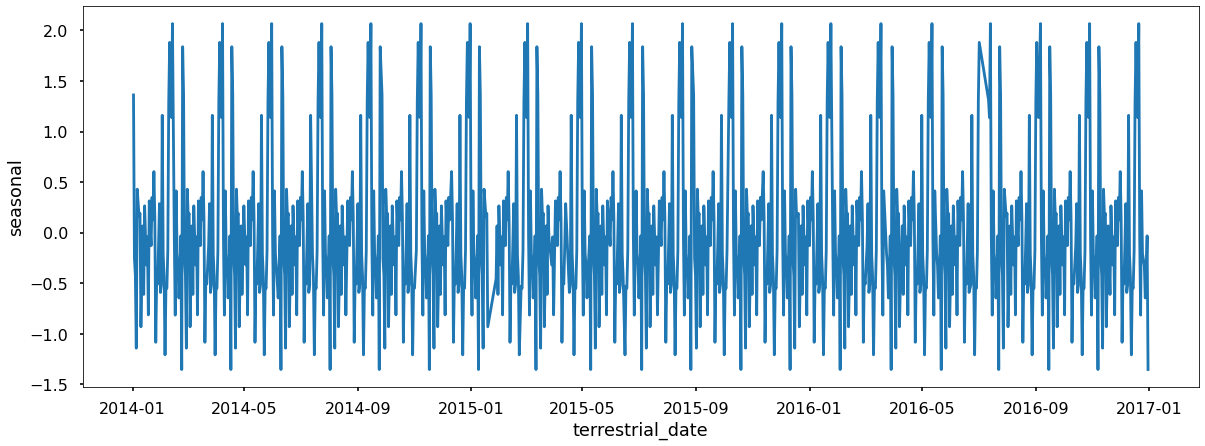

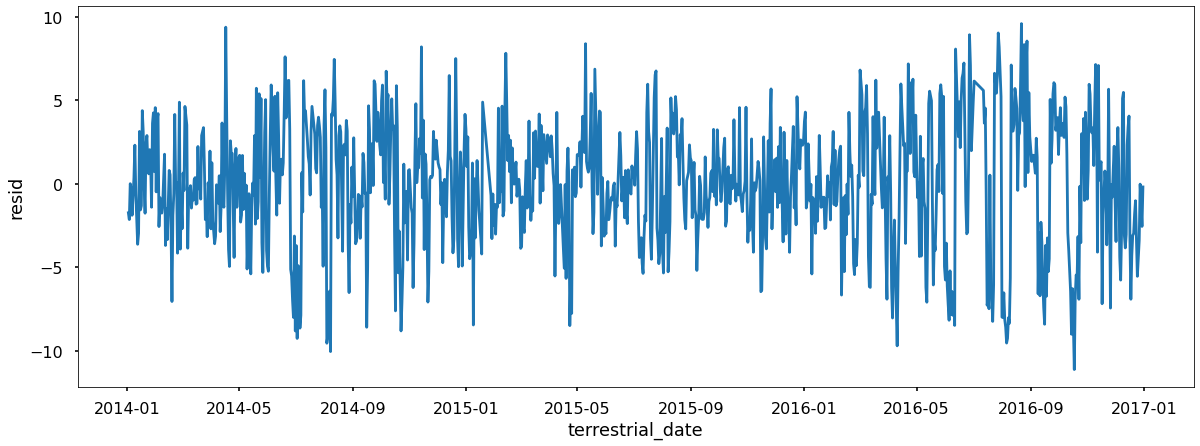

In [61]:
plot_signal_decomposition(mars_weather_year, "max_temp")

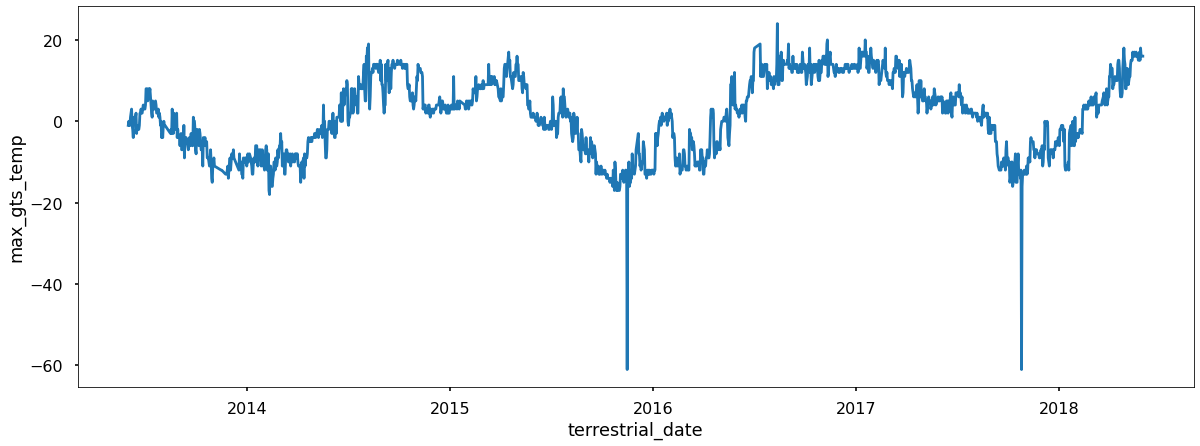

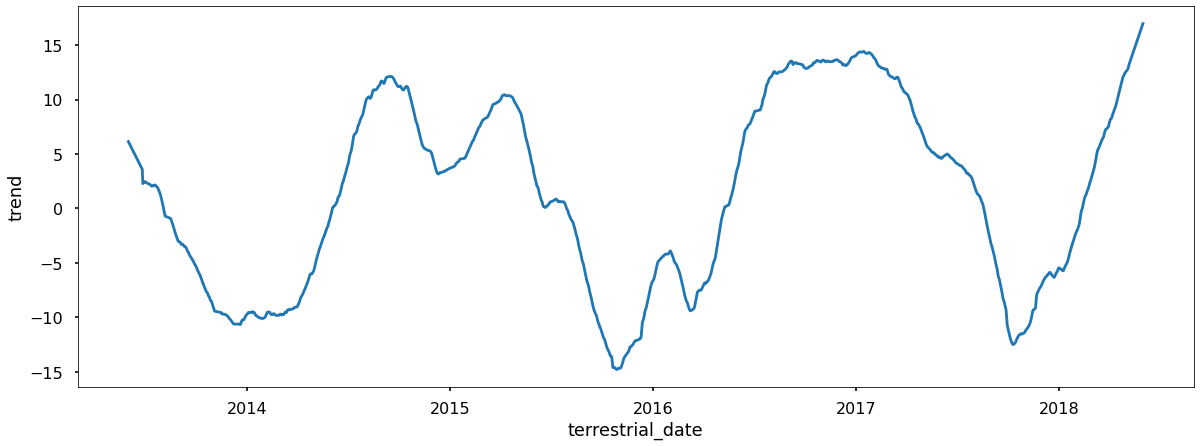

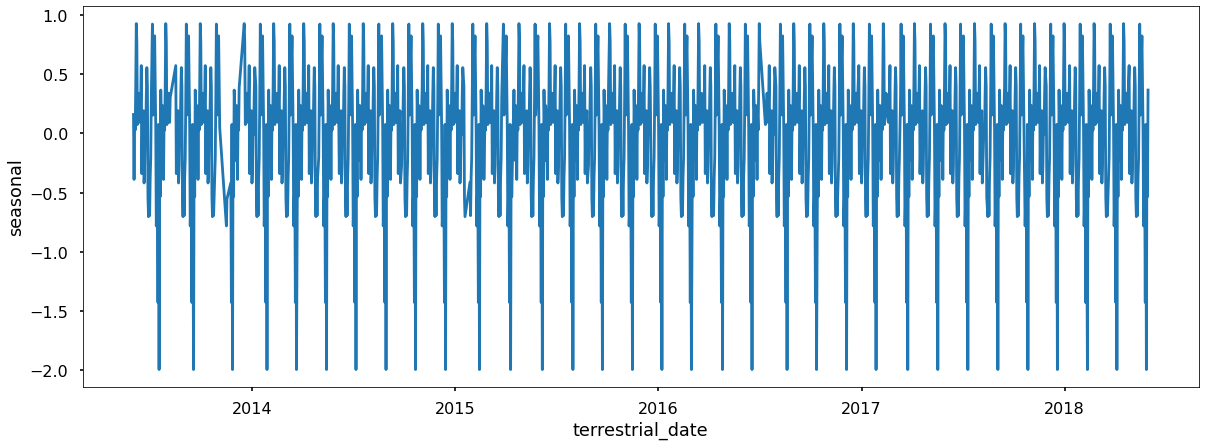

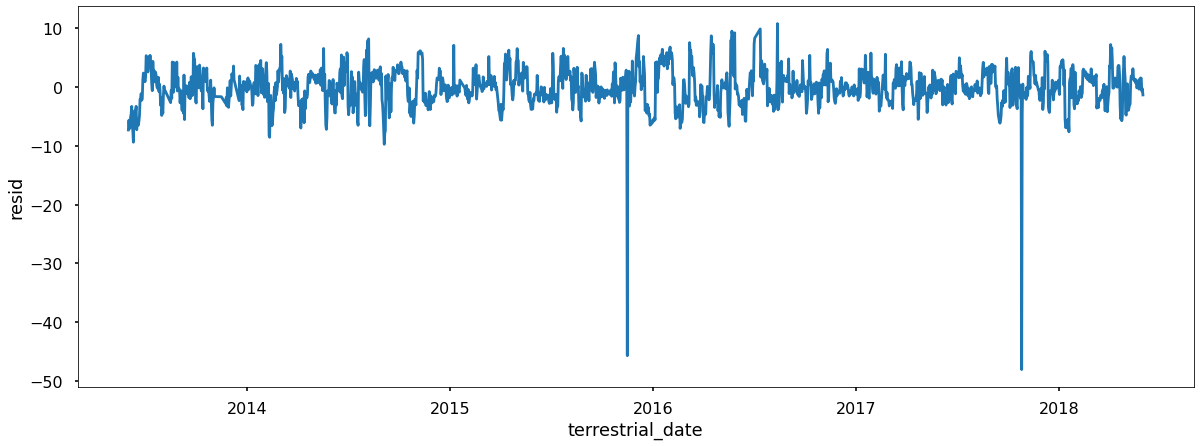

In [26]:
plot_signal_decomposition(mars_weather_df, "max_gts_temp")

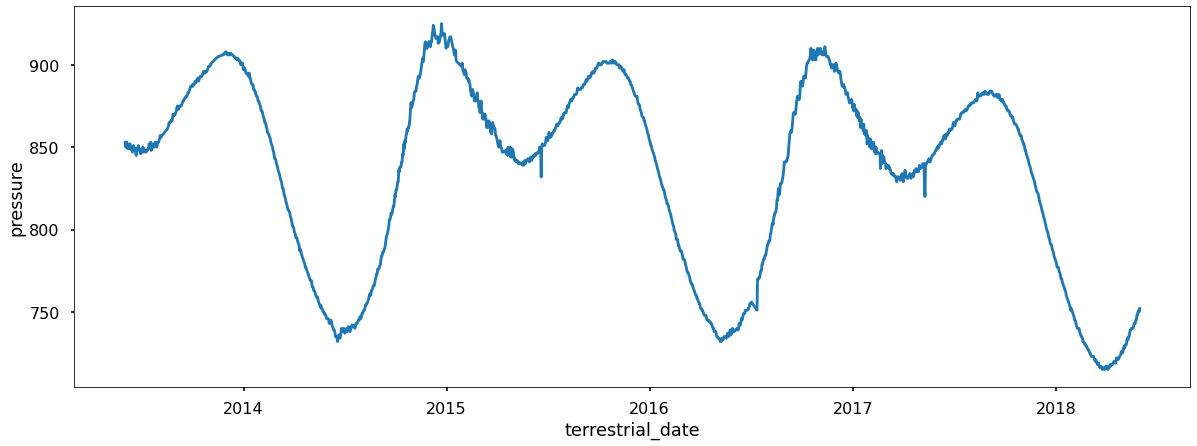

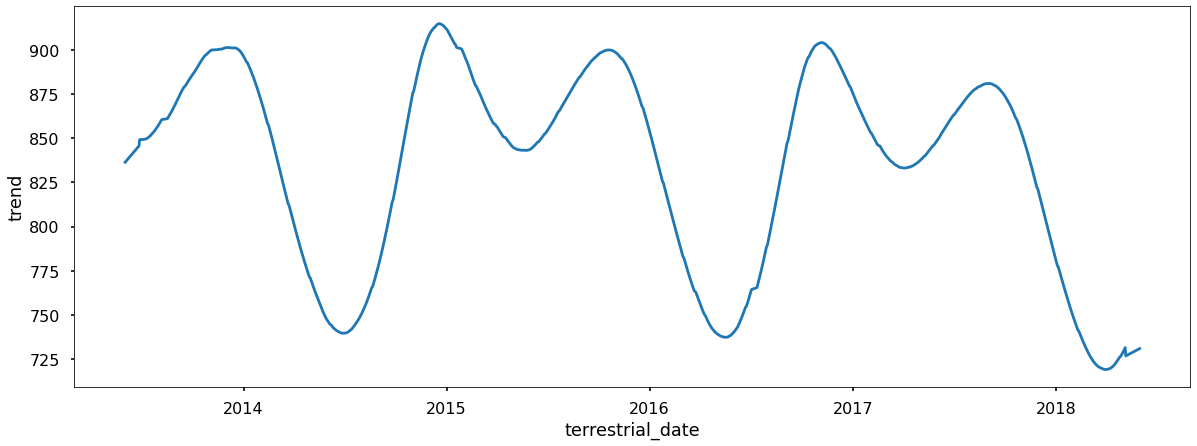

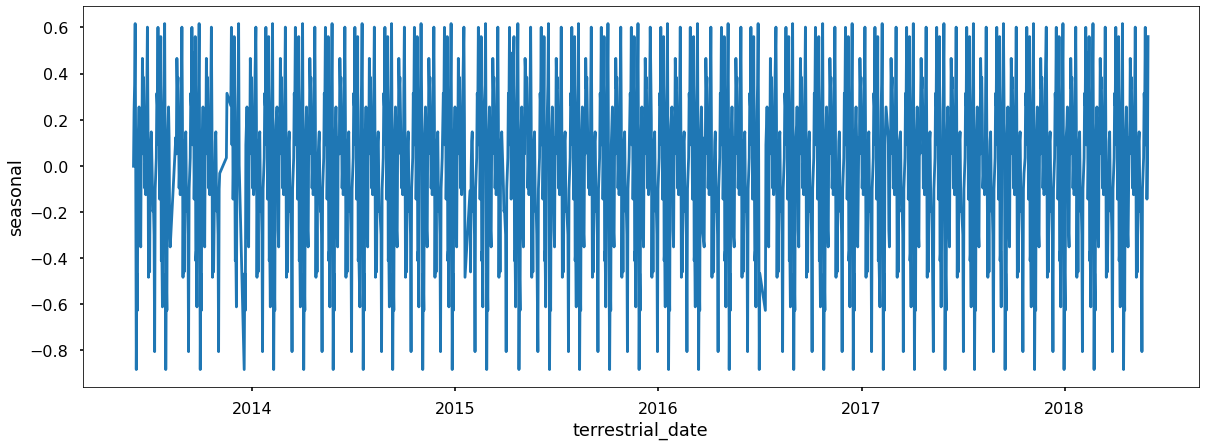

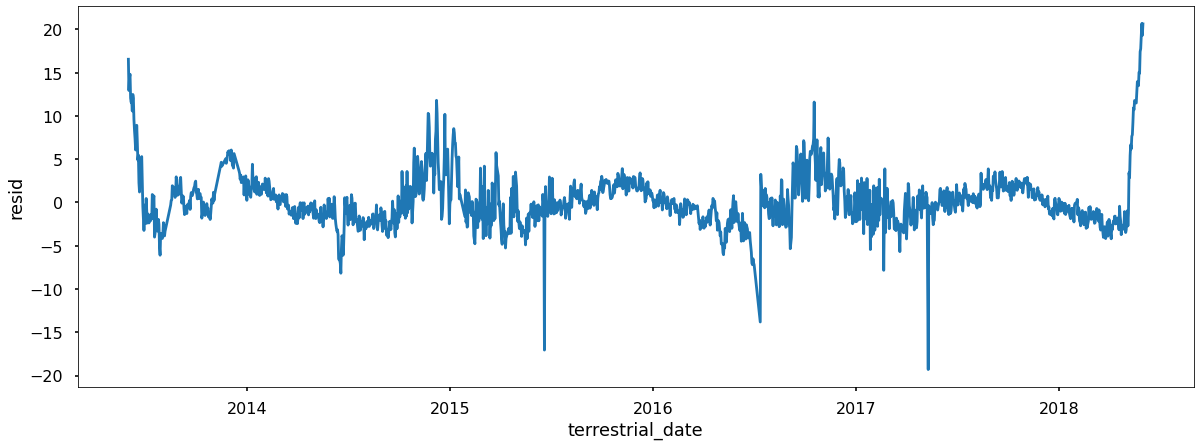

In [30]:
plot_signal_decomposition(mars_weather_df, "pressure")

## ACF and PACF
- Detect non-stationarity
- Determine the order of AR and MA terms in SARIMAX

In [30]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [31]:
def plot_acf_and_pacf(df, column_name): 
    f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

    plot_acf(df[column_name], lags=200, ax=ax[0])
    plot_pacf(df[column_name], lags=100, ax=ax[1])

    plt.show()


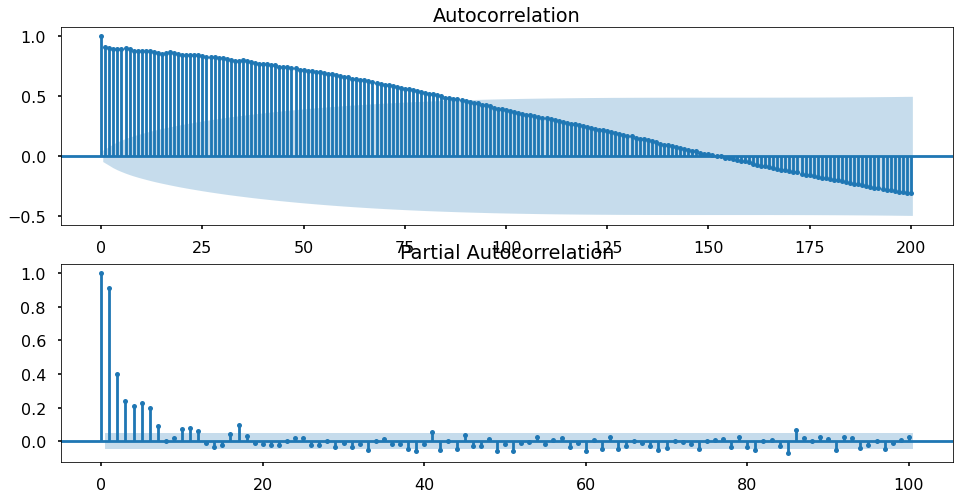

In [32]:
plot_acf_and_pacf(mars_weather_df, "min_temp")

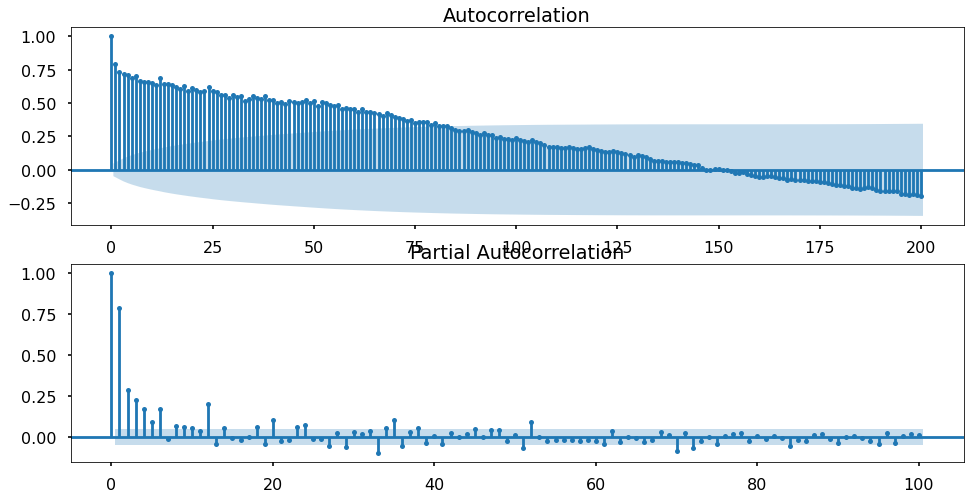

In [33]:
plot_acf_and_pacf(mars_weather_df, "min_gts_temp")

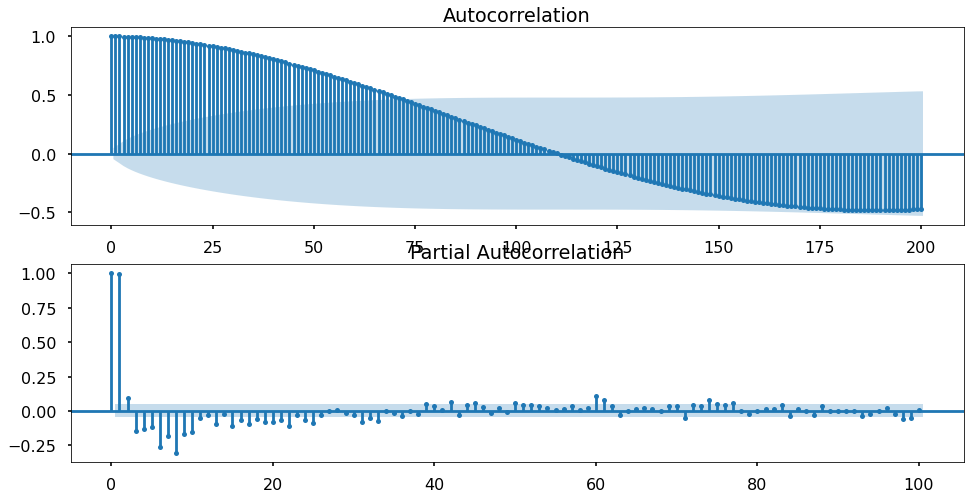

In [34]:
plot_acf_and_pacf(mars_weather_df, "pressure")

- Strong indication of non stationarity, since many lags before autocorrelation tends to 0

## Check for Stationarity

- Confirm non-stationarity with ADF test

In [45]:
from statsmodels.tsa.stattools import adfuller

In [48]:
def apply_adf_test(df, column_name): 
    adf_test = adfuller(df[column_name].values)
    
    return adf_test

In [50]:
for quantity in ["min_temp", "max_temp", "min_gts_temp", "max_gts_temp", "pressure"]:
    result = apply_adf_test(mars_weather_df, quantity)
    print(f"p-value for {quantity} is {result[1]}")

p-value for min_temp is 0.5502945590575415
p-value for max_temp is 0.5836752427076648
p-value for min_gts_temp is 0.08605714288964017
p-value for max_gts_temp is 0.18541930372820792
p-value for pressure is 4.932299383032722e-10


- Using 5% level of significance, out of all quantities only the p-value of the ADF test for pressure allows us to reject the null hypothesis i.e that the time series has a unit root and thus is non-stanionery. 
- So all temperature signals are non-stationery and must be corrected to account for this. 

## Determine order of differencing (integrated term)

Find the lowest order of differencing that gives:
- Time series with constant mean. 
- ACF that decays rapidly to 0 (means that there is no longer long term trends in the time series)

In [40]:
mars_weather_df["min_temp_difference1"] = mars_weather_df.min_temp.diff()
mars_weather_df["max_temp_difference1"] = mars_weather_df.max_temp.diff()

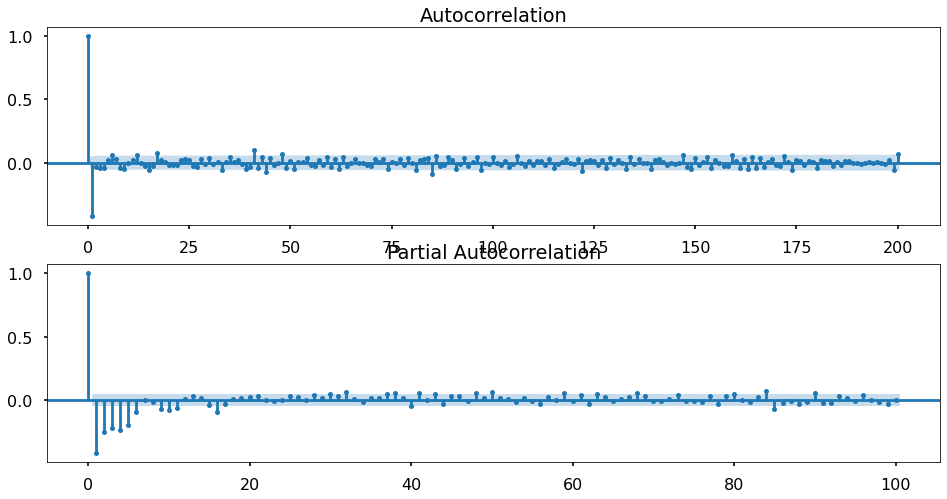

In [49]:
plot_acf_and_pacf(mars_weather_df.dropna(), "min_temp_difference1")

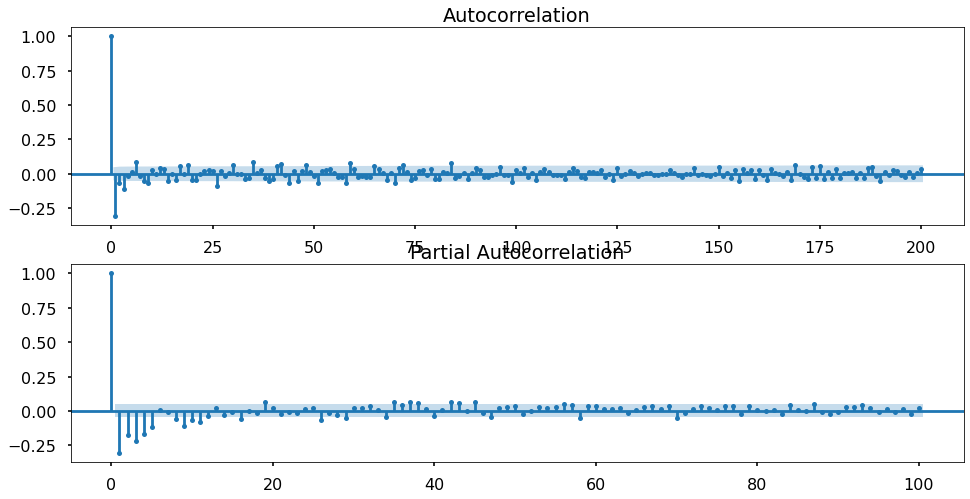

In [50]:
plot_acf_and_pacf(mars_weather_df.dropna(), "max_temp_difference1")

<AxesSubplot:xlabel='terrestrial_date', ylabel='min_temp'>

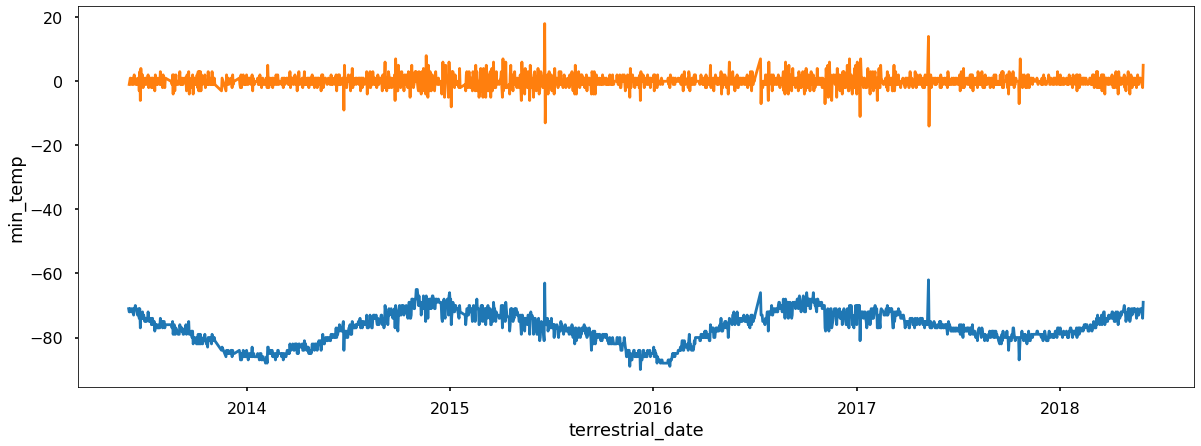

In [52]:
plt.figure(figsize=(20, 7))
sns.lineplot(mars_weather_df.terrestrial_date, mars_weather_df.min_temp)
sns.lineplot(mars_weather_df.terrestrial_date, mars_weather_df.min_temp_difference1)

<AxesSubplot:xlabel='terrestrial_date', ylabel='max_temp'>

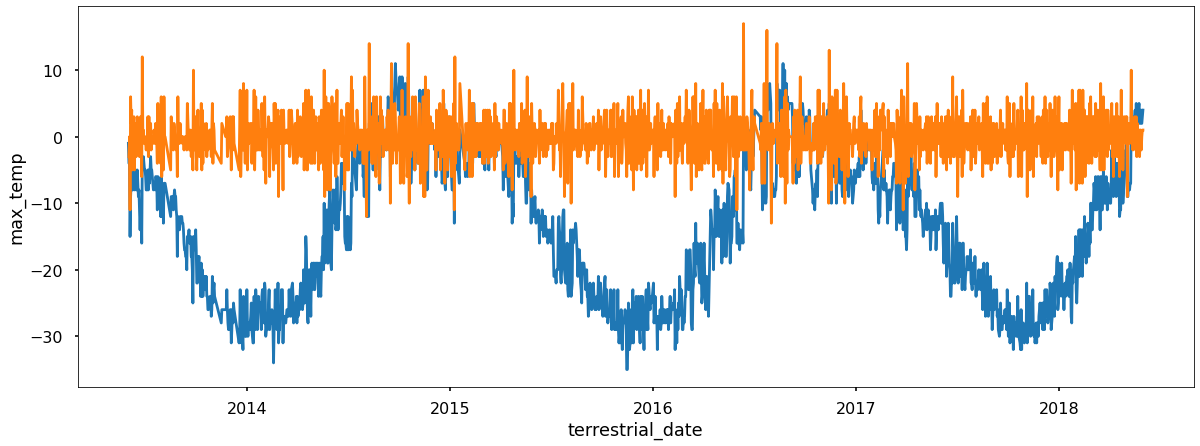

In [53]:
plt.figure(figsize=(20, 7))
sns.lineplot(mars_weather_df.terrestrial_date, mars_weather_df.max_temp)
sns.lineplot(mars_weather_df.terrestrial_date, mars_weather_df.max_temp_difference1)

- Only 1 order of differencing is required for time series with constant mean and ACF to deay quickly to 0. 

## Determine AR and MA terms
- From ACF and PACF plots of the differnced series above, both AR and MA terms should be set to 1. 
- Number of lags before falling to 0. 

## SARIMAX model

### Fit model

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

In [16]:
mars_weather_df.reset_index(inplace=True)
mars_weather_df.head()

,index,terrestrial_date,sol,min_temp,max_temp,pressure,min_gts_temp,max_gts_temp
0,245,2013-06-02,292,-71,-1,853,-71,-1
1,246,2013-06-03,293,-72,-4,850,-72,0
2,247,2013-06-04,294,-72,-4,852,-71,-1
3,248,2013-06-05,295,-71,-15,853,-71,-1
4,249,2013-06-06,296,-71,-9,850,-73,1


In [17]:
train_size = int(len(mars_weather_df) * 0.9)
test_size = int(len(mars_weather_df)) - train_size

train_df = mars_weather_df.loc[:train_size]
test_df = mars_weather_df.loc[train_size:]

In [18]:
#sarimax_model = SARIMAX(train_df.min_temp, order=(1, 1, 1), seasonal_order=(1, 1, 1, 100))
sarimax_model = ARIMA(train_df.min_temp, order=(1, 1, 1), seasonal_order=(1, 1, 1, 350))

In [19]:
model_results = sarimax_model.fit(method='innovations_mle', low_memory=True, cov_type='none')

c:\users\alok suresh\appdata\local\pypoetry\cache\virtualenvs\marsweather-c1whw1yy-py3.7\lib\site-packages\statsmodels\tsa\arima\model.py:376: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  ' estimation by method "%s".' % method)


c:\users\alok suresh\appdata\local\pypoetry\cache\virtualenvs\marsweather-c1whw1yy-py3.7\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


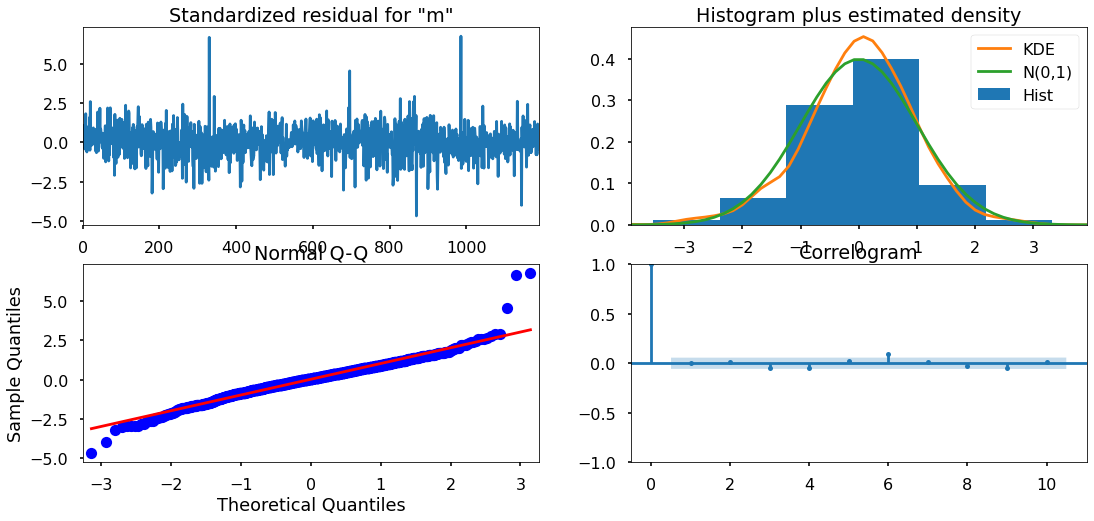

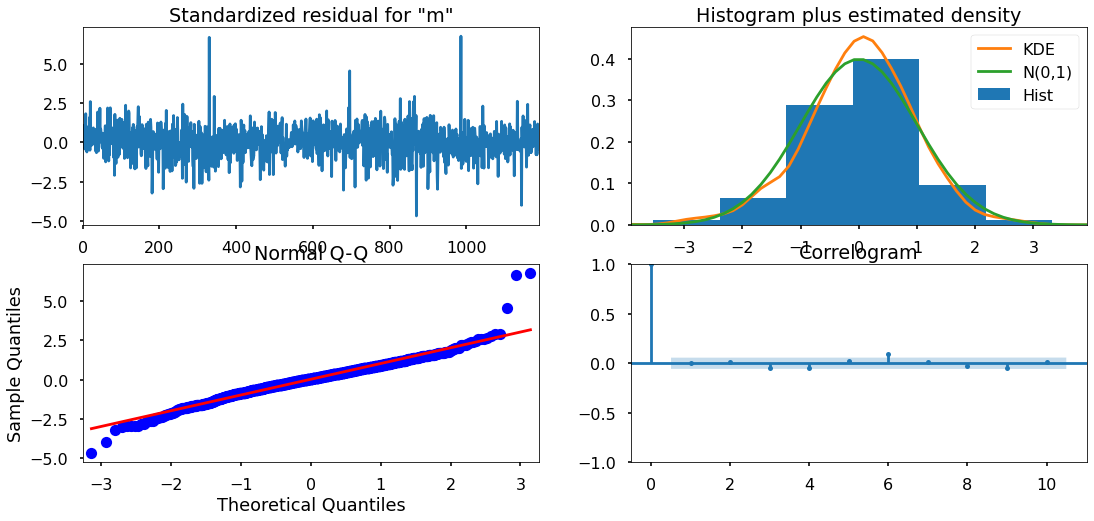

In [20]:
model_results.plot_diagnostics(figsize=(18, 8))


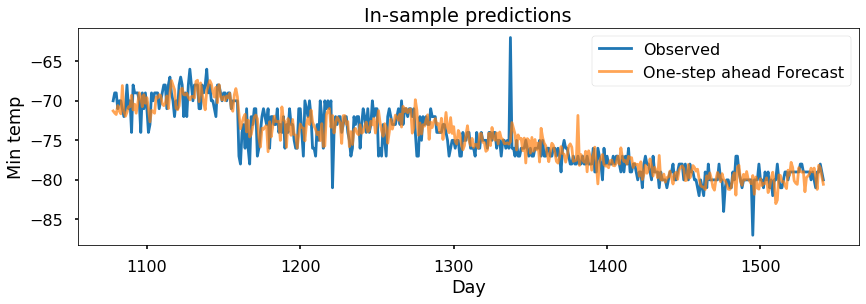

In [23]:
preds = model_results.get_prediction(start=int(train_size*0.7))
pred_ci = preds.conf_int()
ax = train_df.min_temp.loc[int(train_size*0.7):].plot(label='Observed')
preds.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Day')
ax.set_ylabel('Min temp')
ax.set_title("In-sample predictions")
plt.legend()
plt.show()


In [27]:
y_pred = preds.predicted_mean
y_train = train_df.loc[int(train_size*0.7):, "min_temp"].values
mse = ((y_pred - y_train)**2).mean()
rmse = np.sqrt(mse)

print("MSE: ", mse)
print("RMSE: ", rmse)

MSE:  4.13389593744394
RMSE:  2.0331984500889084


In [28]:
print(mars_weather_df.shape)
print(train_size)
print(test_size)

(1713, 8)
1541
172


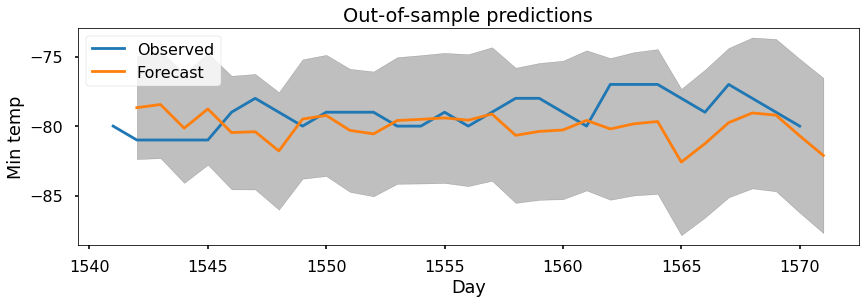

In [30]:
forecast_steps = 30

y_pred_forecast = model_results.get_forecast(steps=forecast_steps)
pred_ci = y_pred_forecast.conf_int()

ax = test_df.min_temp[:forecast_steps].plot(label='Observed', figsize=(14, 4))

y_pred_forecast.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],
    pred_ci.iloc[:, 1], color='k', 
    alpha=.25
)

ax.set_xlabel('Day')
ax.set_ylabel('Min temp')
ax.set_title("Out-of-sample predictions")
plt.legend()
plt.show()